In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install tensorboard

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torchvision.models as models


In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


class MyDataset(Dataset):
    def __init__(self, folder_path):
        self.data = []
        self.labels = []
        self.max_length = 0
        self.feature_count = 0
        label_map = {}  # 用于映射字符标签到整数标签的字典
        label_index = 0
        for file_name in os.listdir(folder_path):
            if file_name.endswith('embedding_txt'):
                self.feature_count += 1
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as f:
                    for line in f:
                        mfcc_features = [float(x) for x in line.split()]
                        if len(mfcc_features) > self.max_length:
                           self.max_length = len(mfcc_features)
        dataset_size = self.feature_count
        print("Feature amounts: ",self.feature_count)
        print("Dataset size: ",dataset_size)
                    
        for file_name in os.listdir(folder_path):
            if file_name.endswith('embedding_txt'):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as f:
                    for line in f:
                        mfcc_features = [float(x) for x in line.split()]
                        # 填充特征向量到相同长度
                        if len(mfcc_features)< self.max_length:
                            mfcc_features = self.paddingByMaxLength(mfcc_features)
                        mfcc_features_tensor = torch.tensor(mfcc_features, dtype=torch.float32)
                        self.data.append(mfcc_features_tensor)
                        speaker_id = os.path.basename(file_path)[:3]
                        if speaker_id not in label_map:
                            label_map[speaker_id] = label_index
                            label_index += 1
                        self.labels.append(label_map[speaker_id])
        print("Label size: ",len(self.labels))
                        
    def paddingByMaxLength(self, features):
        if len(features) < self.max_length:
            padded_features = features + [0.0] * (self.max_length - len(features))
            return padded_features
        return features

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        features_tensor = self.data[idx]
        label_tensor = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return {'features': features_tensor, 'label': label_tensor}


dataset_size = 0       
batch_size = 64
train_path = '../../split_data/train'
valid_path = '../../split_data/validation'
test_path = '../../split_data/test'
train_dataset = MyDataset(train_path)
val_dataset = MyDataset(valid_path)
test_dataset = MyDataset(test_path)
def train_dataloader(train_dataset):
        return DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

def val_dataloader(val_dataset):
        return DataLoader(dataset=val_dataset, batch_size=batch_size)

def test_dataloader(test_dataset):
        return DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#loading dataloader
trainloader = train_dataloader(train_dataset)
validationloader = val_dataloader(val_dataset)
testloader = test_dataloader(test_dataset)


Feature amounts:  729
Dataset size:  729
Label size:  729
Feature amounts:  149
Dataset size:  149
Label size:  149
Feature amounts:  140
Dataset size:  140
Label size:  140


In [4]:
from PIL import Image
from torchvision import transforms

class MyMelDataset(Dataset):
    
    def __init__(self, folder_path,transform):
        self.transform = transform
        self.data = []
        self.labels = []
        self.feature_count = 0
        label_map = {}  # 用于映射字符标签到整数标签的字典
        label_index = 0
        for file_name in os.listdir(folder_path):
            if file_name.endswith('png'):
                self.feature_count += 1
                img_name = os.path.join(folder_path,file_name)
                image = Image.open(img_name)
                image_tensor = self.transform(image)
                self.data.append(image_tensor)
                speaker_id = os.path.basename(file_name)[:3]
                if speaker_id not in label_map:
                            label_map[speaker_id] = label_index
                            label_index += 1
                self.labels.append(label_map[speaker_id])
        print("Feature amounts: ", self.feature_count)        
        print("Label size: ",len(self.labels))
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        features_tensor = self.data[idx]
        label_tensor = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return {'features': features_tensor, 'label': label_tensor}
    
transform = transforms.Compose([
    transforms.Resize((140, 56)),  # 调整图像大小
    transforms.ToTensor(),           # 转换为张量
    transforms.Normalize(mean=[0.5], std=[0.5])  # 标准化
])

train_path_Mel = '../../split_data/train_Mel'
valid_path_Mel = '../../split_data/validation_Mel'
test_path_Mel = '../../split_data/test_Mel'

train_dataset_Mel= MyMelDataset(train_path_Mel,transform=transform)
val_dataset_Mel = MyMelDataset(valid_path_Mel,transform = transform)
test_dataset_Mel = MyMelDataset(test_path_Mel, transform= transform)

trainloader_Mel = train_dataloader(train_dataset_Mel)
validationloader_Mel = val_dataloader(val_dataset_Mel)
testloader_Mel = test_dataloader(test_dataset_Mel)

Feature amounts:  608
Label size:  608
Feature amounts:  76
Label size:  76
Feature amounts:  76
Label size:  76


In [5]:

for data in trainloader_Mel:
    print("Features shape:", data['features'].shape)
    print("Labels shape:", data['label'].shape)
    print(data['label'])

Features shape: torch.Size([64, 4, 140, 56])
Labels shape: torch.Size([64])
tensor([0, 9, 6, 0, 8, 1, 9, 8, 5, 3, 3, 7, 4, 7, 2, 0, 1, 5, 2, 3, 1, 2, 8, 5,
        1, 0, 7, 3, 4, 3, 5, 0, 2, 0, 4, 3, 1, 4, 9, 5, 9, 3, 0, 1, 9, 0, 5, 5,
        1, 3, 9, 3, 2, 4, 6, 2, 8, 6, 5, 9, 2, 9, 2, 6])
Features shape: torch.Size([64, 4, 140, 56])
Labels shape: torch.Size([64])
tensor([3, 2, 7, 5, 7, 3, 3, 3, 1, 5, 3, 1, 5, 2, 0, 3, 1, 5, 5, 8, 6, 2, 3, 0,
        6, 2, 5, 0, 9, 5, 3, 2, 1, 2, 5, 0, 2, 0, 3, 6, 2, 2, 1, 2, 4, 5, 6, 0,
        1, 8, 2, 1, 7, 9, 7, 2, 2, 6, 9, 3, 5, 5, 3, 6])
Features shape: torch.Size([64, 4, 140, 56])
Labels shape: torch.Size([64])
tensor([2, 9, 2, 3, 7, 7, 4, 4, 7, 0, 7, 8, 5, 1, 5, 8, 1, 1, 8, 8, 3, 1, 3, 9,
        5, 0, 0, 5, 5, 5, 7, 7, 9, 4, 5, 5, 5, 4, 0, 9, 9, 7, 3, 3, 3, 6, 5, 7,
        3, 7, 9, 2, 3, 7, 5, 8, 5, 2, 3, 6, 6, 9, 9, 0])
Features shape: torch.Size([64, 4, 140, 56])
Labels shape: torch.Size([64])
tensor([9, 0, 2, 9, 2, 0, 5, 0, 9, 5, 9, 3, 2

In [11]:
resNetModel = models.resnet50(pretrained = True)
# 获取第一个卷积层的权重
conv1_weight = resNetModel.conv1.weight

# 将通道数修改为1
modified_conv1_weight = conv1_weight[:, :4, :, :]

# 修改模型的第一个卷积层的权重
resNetModel.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#resNetModel.conv1.weight.data = modified_conv1_weight

# 检查修改后的模型结构
print(resNetModel)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

Number of mini-batches in one epoch: 10
Epoch 1, Batch 10, Loss: 0.304066
Epoch 1, Validation Accuracy: 71.052632%
Best model saved with validation accuracy: 71.05263157894737
Epoch 2, Batch 10, Loss: 0.068640
Epoch 2, Validation Accuracy: 73.684211%
Best model saved with validation accuracy: 73.68421052631578
Epoch 3, Batch 10, Loss: 0.032811
Epoch 3, Validation Accuracy: 72.368421%
Epoch 4, Batch 10, Loss: 0.022774
Epoch 4, Validation Accuracy: 73.684211%
Epoch 5, Batch 10, Loss: 0.014768
Epoch 5, Validation Accuracy: 75.000000%
Best model saved with validation accuracy: 75.0
Epoch 6, Batch 10, Loss: 0.011987
Epoch 6, Validation Accuracy: 76.315789%
Best model saved with validation accuracy: 76.31578947368422
Epoch 7, Batch 10, Loss: 0.004598
Epoch 7, Validation Accuracy: 77.631579%
Best model saved with validation accuracy: 77.63157894736842
Epoch 8, Batch 10, Loss: 0.003573
Epoch 8, Validation Accuracy: 81.578947%
Best model saved with validation accuracy: 81.57894736842105
Epoch 9

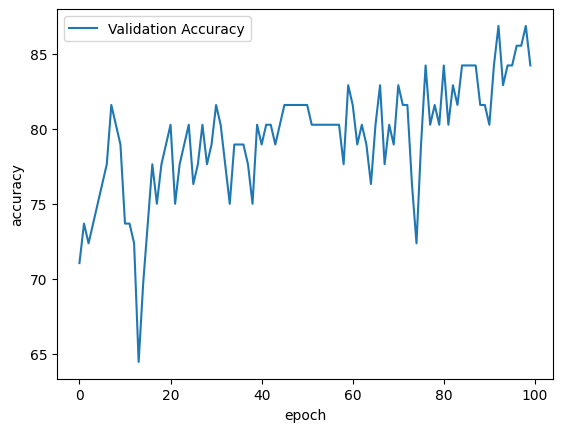

In [12]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resNetModel.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resNetModel.parameters(), lr=0.001)

log_dir = "./logs/resNet50"
writer = SummaryWriter(log_dir)

best_accuracy = 0.0  # 初始化最佳准确率为0
best_model_path = "./best_restNetmodel.pth"  # 模型保存路径

train_losses = []
validations = []
print("Number of mini-batches in one epoch:", len(trainloader_Mel))
for epoch in range(100):
    running_loss = 0.0  
    for i, data in enumerate(trainloader_Mel, 0):
        inputs_origin = data['features']
        inputs_new = inputs_origin.squeeze(1).squeeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        optimizer.zero_grad()

        outputs = resNetModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % len(trainloader_Mel) == len(trainloader_Mel) - 1:
            average_loss = running_loss / 100
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {average_loss:.6f}")

            train_losses.append(average_loss)

            running_loss = 0.0

    # 在每个epoch结束后执行验证集评估
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader_Mel:
            inputs_origin = data['features']
            inputs_new = inputs_origin.squeeze(1).squeeze(2)
            inputs, labels = inputs_new.to(device), data['label'].to(device)
            outputs = resNetModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    validations.append(accuracy)
    print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.6f}%")

    # 如果当前模型在验证集上表现优于之前的最佳表现，则保存当前模型参数
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(resNetModel.state_dict(), best_model_path)
        print("Best model saved with validation accuracy:", best_accuracy)
print("After training, the best model saved with validation accuracy:", best_accuracy)    
plt.plot(validations, label = "Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
print("resNetModel Training finished")

In [7]:
mobileNetModel = models.mobilenet_v2(pretrained = True)
# 修改第一个卷积层的输入通道数
mobileNetModel.features[0][0] = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# 打印修改后的模型结构
print(mobileNetModel)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of mini-batches in one epoch: 10
Epoch 1, Batch 10, Loss: 0.376257
Epoch 1, Validation Accuracy: 63.157895%
Best model saved with validation accuracy: 63.1578947368421
Epoch 2, Batch 10, Loss: 0.063764
Epoch 2, Validation Accuracy: 68.421053%
Best model saved with validation accuracy: 68.42105263157895
Epoch 3, Batch 10, Loss: 0.022012
Epoch 3, Validation Accuracy: 75.000000%
Best model saved with validation accuracy: 75.0
Epoch 4, Batch 10, Loss: 0.015712
Epoch 4, Validation Accuracy: 82.894737%
Best model saved with validation accuracy: 82.89473684210526
Epoch 5, Batch 10, Loss: 0.007730
Epoch 5, Validation Accuracy: 77.631579%
Epoch 6, Batch 10, Loss: 0.004611
Epoch 6, Validation Accuracy: 72.368421%
Epoch 7, Batch 10, Loss: 0.002838
Epoch 7, Validation Accuracy: 75.000000%
Epoch 8, Batch 10, Loss: 0.002860
Epoch 8, Validation Accuracy: 78.947368%
Epoch 9, Batch 10, Loss: 0.000613
Epoch 9, Validation Accuracy: 76.315789%
Epoch 10, Batch 10, Loss: 0.000914
Epoch 10, Validation

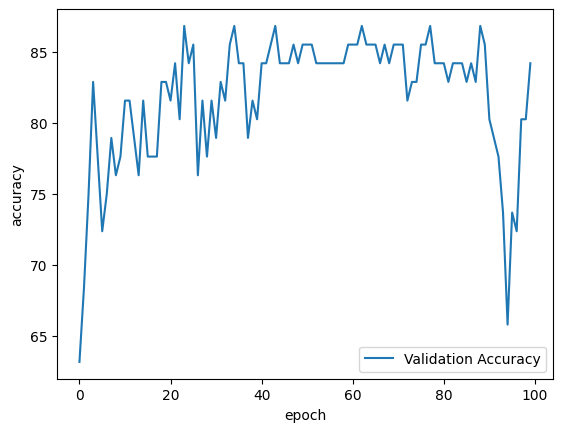

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobileNetModel.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobileNetModel.parameters(), lr=0.001)

log_dir = "./logs/mobileNet_v2"
writer = SummaryWriter(log_dir)

best_accuracy = 0.0  # 初始化最佳准确率为0
best_model_path = "./best_mobilemodel.pth"  # 模型保存路径

validations = []

print("Number of mini-batches in one epoch:", len(trainloader_Mel))
for epoch in range(100):
    running_loss = 0.0  
    for i, data in enumerate(trainloader_Mel, 0):
        inputs_origin = data['features']
        inputs_new = inputs_origin.squeeze(1).squeeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        optimizer.zero_grad()

        outputs = mobileNetModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % len(trainloader_Mel) == len(trainloader_Mel) - 1:
            average_loss = running_loss / 100
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {average_loss:.6f}")

            running_loss = 0.0

    # 在每个epoch结束后执行验证集评估
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader_Mel:
            inputs_origin = data['features']
            inputs_new = inputs_origin.squeeze(1).squeeze(2)
            inputs, labels = inputs_new.to(device), data['label'].to(device)
            outputs = mobileNetModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    validations.append(accuracy)
    print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.6f}%")

    # 如果当前模型在验证集上表现优于之前的最佳表现，则保存当前模型参数
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(mobileNetModel.state_dict(), best_model_path)
        print("Best model saved with validation accuracy:", best_accuracy)

print("After training, the best model saved with validation accuracy:", best_accuracy)   
plt.plot(validations, label = "Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
print("mobileNetModel Training finished")

In [8]:
denseNetModel = models.densenet201(pretrained = True)
# 修改第一个卷积层的输入通道数
denseNetModel.features.conv0 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# 打印修改后的模型结构
print(denseNetModel)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Number of mini-batches in one epoch: 10
Epoch 1, Validation Accuracy: 53.947368%
Best model saved with validation accuracy: 53.94736842105263
Epoch 2, Validation Accuracy: 67.105263%
Best model saved with validation accuracy: 67.10526315789474
Epoch 3, Validation Accuracy: 65.789474%
Epoch 4, Validation Accuracy: 76.315789%
Best model saved with validation accuracy: 76.31578947368422
Epoch 5, Validation Accuracy: 72.368421%
Epoch 6, Validation Accuracy: 73.684211%
Epoch 7, Validation Accuracy: 68.421053%
Epoch 8, Validation Accuracy: 67.105263%
Epoch 9, Validation Accuracy: 68.421053%
Epoch 10, Validation Accuracy: 65.789474%
Epoch 11, Validation Accuracy: 67.105263%
Epoch 12, Validation Accuracy: 75.000000%
Epoch 13, Validation Accuracy: 73.684211%
Epoch 14, Validation Accuracy: 76.315789%
Epoch 15, Validation Accuracy: 77.631579%
Best model saved with validation accuracy: 77.63157894736842
Epoch 16, Validation Accuracy: 72.368421%
Epoch 17, Validation Accuracy: 73.684211%
Epoch 18, V

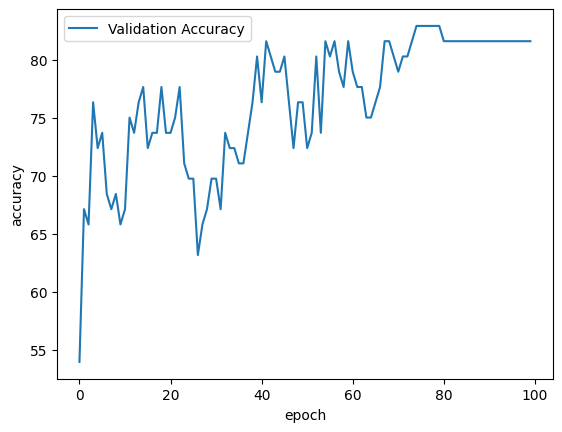

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
denseNetModel.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(denseNetModel.parameters(), lr=0.001)

log_dir = "./logs/resNet50"
writer = SummaryWriter(log_dir)

best_accuracy = 0.0  # 初始化最佳准确率为0
best_model_path = "./best_denseNetmodel.pth"  # 模型保存路径
validations = []

print("Number of mini-batches in one epoch:", len(trainloader_Mel))
for epoch in range(100):
    running_loss = 0.0  
    for i, data in enumerate(trainloader_Mel, 0):
        inputs_origin = data['features']
        inputs_new = inputs_origin.squeeze(1).squeeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        optimizer.zero_grad()

        outputs = denseNetModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % len(trainloader) == len(trainloader) - 1:
            average_loss = running_loss / 100
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {average_loss:.6f}")

            global_step = epoch * len(trainloader) + i
            writer.add_scalar("Loss", average_loss, global_step)

            running_loss = 0.0

    # 在每个epoch结束后执行验证集评估
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader_Mel:
            inputs_origin = data['features']
            inputs_new = inputs_origin.squeeze(1).squeeze(2)
            inputs, labels = inputs_new.to(device), data['label'].to(device)
            outputs = denseNetModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    validations.append(accuracy)
    print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.6f}%")

    # 如果当前模型在验证集上表现优于之前的最佳表现，则保存当前模型参数
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        
        torch.save(denseNetModel.state_dict(), best_model_path)
        print("Best model saved with validation accuracy:", best_accuracy)
print("After training, the best model saved with validation accuracy:", best_accuracy)   
plt.plot(validations, label = "Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
print("denseNetModel Training finished")

In [6]:
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

class _Layer1(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(_Layer1,self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, growth_rate, kernel_size=3,padding=1, stride=1,bias=False)
        self.bn1 = torch.nn.BatchNorm2d(growth_rate)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(growth_rate,32,kernel_size=3, stride=1, padding=1,bias=False)
    
    def forward(self, x):
        out = self.conv2(self.relu1(self.bn1(self.conv1(x))))
        out = torch.cat([x,out],1)
        return out
    

class _Layer2(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(_Layer2,self).__init__()
        self.bn1 = torch.nn.BatchNorm2d(in_channels)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.conv1 = torch.nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1,padding=1,bias=False)
        self.bn2 = torch.nn.BatchNorm2d(growth_rate)
        self.relu2 = torch.nn.ReLU(inplace=True)
        
        self.conv2 = torch.nn.Conv2d(growth_rate,32,kernel_size=3, stride=1,padding=1, bias=False)
    
    def forward(self, x):
        #print("size check of x: ",x.size())
        out = self.conv1(self.relu1(self.bn1(x)))
        out = self.conv2((self.relu2(self.bn2(out))))
        #print("size check of out: ",out.size())
        out = torch.cat([x,out],1)
        return out
    
class _myNet(nn.Module):
    def __init__(self):
        super(_myNet,self).__init__()
        self.features = torch.nn.Sequential(
        torch.nn.Conv2d(4,64,kernel_size=3,stride=1,padding=1,bias=False),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer1 = _Layer1(64,128)
        self.layer2 = _Layer2(96,128)
        self.layer3 = _Layer2(128,128)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.norm = nn.BatchNorm2d(160)
        self.classifier = nn.Linear(160*35*14, 10)
        
    
    def forward(self, x):
        out = self.features(x)
        #print("Feature map size after features layer:", out.size())  # 打印特征图的形状
        out = self.maxpool(self.layer3(self.layer2(self.layer1(out))))
        #print("After layer output size:", out.size(),out.shape()) 
        out = out.view(out.size(0),-1)
        output = self.classifier(out)
        #print("Final output size:", output.size())  # 打印最终输出的形状
        return output

myModel = _myNet()
print(myModel)

_myNet(
  (features): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): _Layer1(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (layer2): _Layer2(
    (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): R

Number of mini-batches in one epoch: 10
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([32, 4, 140, 56])
Epoch 1, Batch 10, Loss: 3.506439
Epoch 1, Validation Accuracy: 13.157895%
Best model saved with validation accuracy: 13.157894736842104
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([64, 4, 140, 56])
Input size: torch.Size([32, 4, 140, 56])
Epo

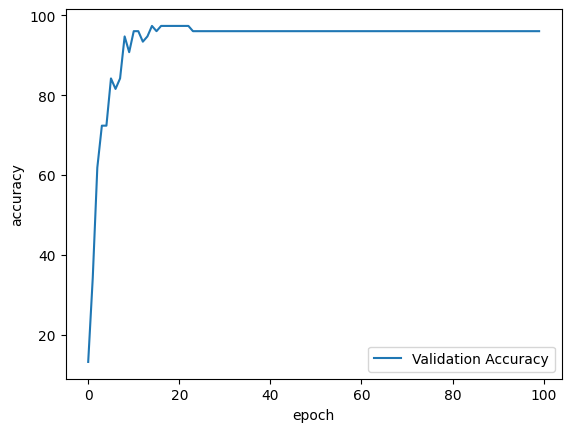

In [6]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myModel.parameters(), lr=0.001)

best_accuracy = 0.0  # 初始化最佳准确率为0
best_model_path = "./best_mymodel.pth"  # 模型保存路径
validations = []

print("Number of mini-batches in one epoch:", len(trainloader_Mel))
for epoch in range(100):
    running_loss = 0.0  
    for i, data in enumerate(trainloader_Mel, 0):
        inputs_origin = data['features']
        inputs_new = inputs_origin.squeeze(1).squeeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        optimizer.zero_grad()
        #print("Input size:", inputs_new.size())
        
        outputs = myModel(inputs)
        outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % len(trainloader_Mel) == len(trainloader_Mel) - 1:
            average_loss = running_loss / 100
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {average_loss:.6f}")
            running_loss = 0.0

    # 在每个epoch结束后执行验证集评估
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validationloader_Mel:
            inputs_origin = data['features']
            inputs_new = inputs_origin.squeeze(1).squeeze(2)
            inputs, labels = inputs_new.to(device), data['label'].to(device)
            outputs = myModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    validations.append(accuracy)
    print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.6f}%")

    # 如果当前模型在验证集上表现优于之前的最佳表现，则保存当前模型参数
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        
        torch.save(myModel.state_dict(), best_model_path)
        print("Best model saved with validation accuracy:", best_accuracy)
print("After training, the best model saved with validation accuracy:", best_accuracy)   
plt.plot(validations, label = "Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
print("Model Training finished")


In [15]:
%pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/79/3d/02d5d3ed359498fec3abdf65407d3c07e3b8765af17464969055aaec5171/scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/1e/84/ccd9b08653022b7785b6e3ee070ffb2825841e0dc119be22f0840b2b35cb/threadpoolctl-3.4.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 1.4 MB/s eta 0:00:08
   - -------------------------------------- 0.3/10.6 MB 4.8 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.6 MB 11.8 MB/s eta 0:00:01
   -------- ------------------------------- 2.4/10.6 MB 18.8 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/10.6 MB 22.5 MB/s eta 0:00:01
   -------------------- ------------------- 5.4/10.6 MB 26.6 MB/s eta 0:00:01
   -------------------------


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import torch
import sklearn
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, f1_score
from tqdm import tqdm

In [13]:
resNetModel.load_state_dict(torch.load("best_restNetmodel.pth"))
resNetModel.eval()
resNetModel.to(device)

all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader_Mel:
        inputs_origin = data['features']
        inputs_new = inputs_origin.squeeze(1).squeeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        outputs = resNetModel(inputs)
     # 计算预测结果
        _, preds = torch.max(outputs, 1)

        # 保存预测结果和真实标签
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

print("The result of resNet:")
print(f"F1 Score: {f1}")
print(f"Precision Score: {precision}")
print(f"Accuracy: {accuracy}")

The result of resNet:
F1 Score: 0.8969100359053854
Precision Score: 0.89
Accuracy: 0.8947368421052632


In [10]:
mobileNetModel.load_state_dict(torch.load("best_mobilemodel.pth"))
mobileNetModel.eval()
mobileNetModel.to(device)

all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader_Mel:
        inputs_origin = data['features']
        inputs_new = inputs_origin.squeeze(1).squeeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        outputs = mobileNetModel(inputs)
     # 计算预测结果
        _, preds = torch.max(outputs, 1)

        # 保存预测结果和真实标签
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

print("The result of mobileNet:")
print(f"F1 Score: {f1}")
print(f"Precision Score: {precision}")
print(f"Accuracy: {accuracy}")

The result of mobileNet:
F1 Score: 0.8550203649397197
Precision Score: 0.8444444444444444
Accuracy: 0.881578947368421


In [11]:
denseNetModel.load_state_dict(torch.load("best_denseNetmodel.pth"))
denseNetModel.eval()
denseNetModel.to(device)

all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader_Mel:
        inputs_origin = data['features']
        inputs_new = inputs_origin.squeeze(1).squeeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        outputs = denseNetModel(inputs)
     # 计算预测结果
        _, preds = torch.max(outputs, 1)

        # 保存预测结果和真实标签
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

print("The result of denseNet:")
print(f"F1 Score: {f1}")
print(f"Precision Score: {precision}")
print(f"Accuracy: {accuracy}")

The result of denseNet:
F1 Score: 0.9420111787853724
Precision Score: 0.9479166666666667
Accuracy: 0.9342105263157895


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
myModel.load_state_dict(torch.load("best_mymodel.pth"))
myModel.eval()
myModel.to(device)

all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader_Mel:
        inputs_origin = data['features']
        inputs_new = inputs_origin.squeeze(1).squeeze(2)
        inputs, labels = inputs_new.to(device), data['label'].to(device)  
        outputs = myModel(inputs)
     # 计算预测结果
        _, preds = torch.max(outputs, 1)

        # 保存预测结果和真实标签
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

print("The result of myModel:")
print(f"F1 Score: {f1}")
print(f"Precision Score: {precision}")
print(f"Accuracy: {accuracy}")

The result of myModel:
F1 Score: 0.8949234931734933
Precision Score: 0.8933868092691621
Accuracy: 0.8947368421052632
